In [ ]:
from functions import *
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
data_filename = '../data/mva_sales.csv'
data_column = 'Used'
date_column = 'Fecha'

data = pd.read_csv(data_filename)
data.head()

In [ ]:
# Arreglo la fecha a aun formato legible
data['Month'] = data['Month'].apply(lambda x: x.capitalize())
data['Year'] = data['Year'].astype(str)
data['Fecha'] = data['Month'] +"-"+ data['Year']
data['Fecha'] = pd.to_datetime(data['Fecha'], format="%b-%Y")
sales = data[[date_column,data_column]].copy()
# Convierto la columna Fecha en índice
sales.index = sales[date_column]
del sales[date_column]
sales.sort_index(inplace=True)

In [ ]:
sales.index.freq = 'MS'
original_sales = sales.copy()
#sales = sales[sales.index < '2020-01-01']
# Replace COVID-era data with a seasonal rolling average
# Replace COVID-era data with interpolated values
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
decomposition = seasonal_decompose(sales['Used'], model='additive', period=12)  # Period = 12 for monthly data

# Replace COVID period with trend + seasonality
covid_period = (sales.index >= '2020-02-01') & (sales.index <= '2020-06-01')
sales.loc[covid_period, 'Used'] = (
    decomposition.trend.loc[covid_period] + decomposition.seasonal.loc[covid_period]
)



sales.shape

In [ ]:
sales.isna().sum()

In [ ]:
# Split into train and test set
steps = 12
sample = len(sales) - steps
sales_train = sales[:sample]
sales_test = sales[sample:]

In [ ]:
# Grafico la serie y obtengo un primera visualización de los datos
plt.figure(figsize=(20, 8))
#plt.plot(sales[data_column].loc[(sales.index >= '2020-02-01') & (sales.index < '2020-07-01')],linewidth = 1, color='darkslateblue')
plt.plot(sales[data_column],linewidth = 1, color='darkslateblue')
plt.xticks(rotation=30,ha='right')
plt.show()

## XGBoost

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

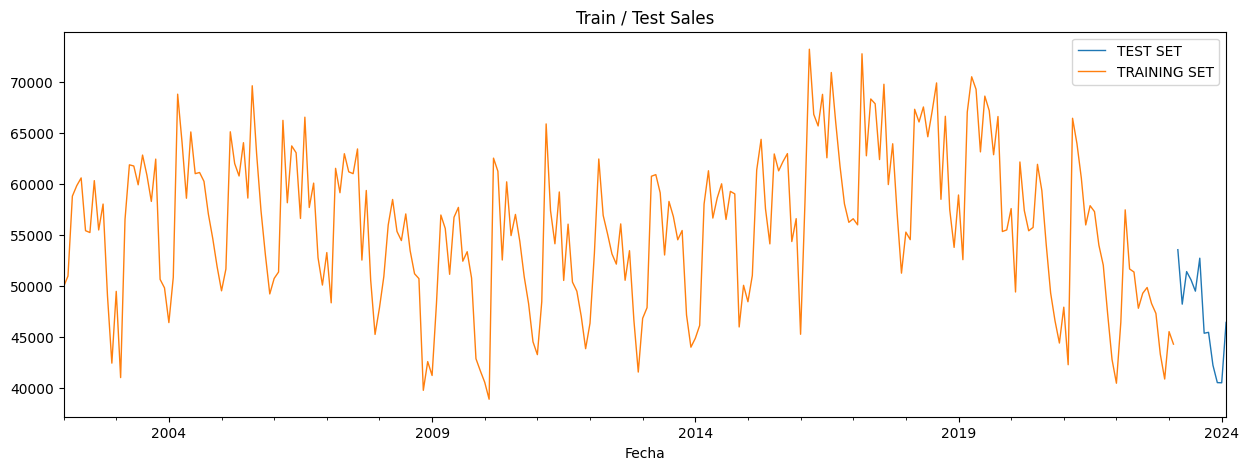

In [9]:
sales_test.rename(columns={data_column:'TEST SET'}).join(sales_train.rename(columns={data_column:'TRAINING SET'}), how='outer').plot(figsize=(15,5),title='Train / Test Sales', style='-',lw=1)

In [10]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
# Set the window size
window_size = 24

# Split data into training and test sets
#X_train, y_train = create_lagged_features(sales_train[data_column].values, window_size)


X_train, y_train = create_features(sales_train, label=data_column)
X_test, y_test = create_features(sales_test, label=data_column)

/home/juancarlos/Documents/dev/sales_forecasting/experiments/functions.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df.index
/home/juancarlos/Documents/dev/sales_forecasting/experiments/functions.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df['date'].dt.hour
/home/juancarlos/Documents/dev/sales_forecasting/experiments/functions.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

In [11]:
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 9, 12],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.4, 0.6, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=12345)

In [12]:
xgb_grid_search = GridSearchCV(estimator=xgb_model, param_grid=xgb_param_grid, cv=tscv, scoring='neg_mean_absolute_percentage_error', n_jobs=-1,verbose=1)
xgb_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, imp...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=12345, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 9, 12],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.4, 0.6, 1.0]},
             scoring='neg_mean_absolute_percentage_error', verbose=1)

In [13]:
xgb_grid_search.best_estimator_.get_params

<bound method XGBModel.get_params of XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=12345, ...)>

In [14]:
sales_test['Predicciones'] = xgb_grid_search.best_estimator_.predict(X_test)
sales_all = pd.concat([sales_test, sales_train], sort=False)

/tmp/ipykernel_29801/1317185890.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_test['Predicciones'] = xgb_grid_search.best_estimator_.predict(X_test)


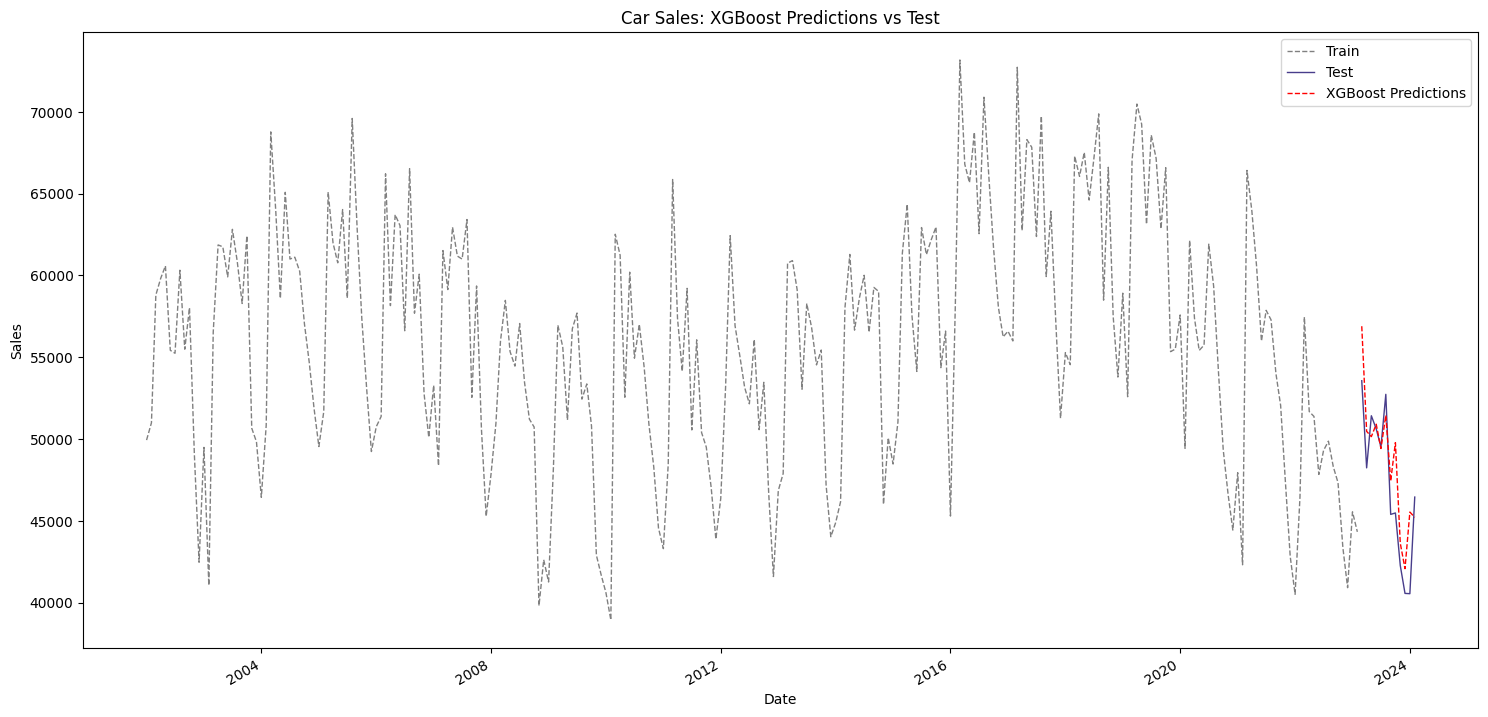

In [15]:
PlotPredictions([
    (sales_train.index,sales_train[data_column],'Train','--','gray'),
    (sales_test.index,sales_test[data_column],'Test','-','darkslateblue'),
    (sales_test.index,sales_test['Predicciones'],'XGBoost Predictions','--','red')],
    'Car Sales: XGBoost Predictions vs Test')

In [16]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
xgb_mape = mean_absolute_percentage_error(sales_test[data_column], sales_test['Predicciones'])
xgb_mae = mean_absolute_error(sales_test[data_column], sales_test['Predicciones'])
print(f'XGBoost MAPE:\t\t{xgb_mape:.2%}')
print(f'XGBoost MAE:\t\t{xgb_mae}')

XGBoost MAPE:		4.37%
XGBoost MAE:		1995.5768229166667


In [17]:
xxx

NameError: name 'xxx' is not defined

## Using the model to replace data from COVID

In [ ]:
start_date = '2020-02-01'
end_date = '2020-06-01'
adjusted_sales = original_sales.copy()

In [ ]:
"""
# Generate predictions for the outlier period using the trained model
outlier_dates = pd.date_range(start=start_date, end=end_date, freq='MS')
predictions = []

for date in outlier_dates:
    # Extract the data up to the current date (for feature generation)
    df_current = adjusted_sales.loc[:date].tail(1)  # Only the current date's data is relevant
    
    # Generate features using `create_features`
    X_pred, _ = create_features(df_current, label='Used')  # Match your label name here

    # Predict the value for the current date
    predicted_value = xgb_grid_search.best_estimator_.predict(X_pred)[0]
    predictions.append(predicted_value)

# Replace the outlier data with predictions
adjusted_sales.loc[start_date:end_date, 'Used'] = predictions

# Verify the adjusted dataframe
print(adjusted_sales.loc[start_date:end_date])
"""

In [ ]:
# Replace COVID-era data with a seasonal rolling average
covid_period = (adjusted_sales.index >= '2020-02-01') & (adjusted_sales.index <= '2020-06-01')
adjusted_sales.loc[covid_period, 'Used'] = adjusted_sales.loc[~covid_period, 'Used'].rolling(window=12, min_periods=1).mean()


In [ ]:
PlotPredictions([
    (adjusted_sales.index,adjusted_sales,'XGBoost Predictions','--','gray')],
    'Car Sales: XGBoost Predictions vs Test')

## Retrain the model

In [ ]:
# Split into train and test set
steps = 24
sample = len(adjusted_sales) - steps
sales_train_new = adjusted_sales[:sample]
sales_test_new = adjusted_sales[sample:]

In [ ]:
sales_test_new.rename(columns={data_column:'TEST SET'}).join(sales_train_new.rename(columns={data_column:'TRAINING SET'}), how='outer').plot(figsize=(15,5),title='Train / Test Sales', style='-',lw=1)

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)
# Set the window size
window_size = 24

# Generate features and targets
X_train_new, y_train_new = create_features(sales_train_new, label=data_column)
X_test_new, y_test_new = create_features(sales_test_new, label=data_column)


# Define parameter grid for XGBoost
xgb_param_grid_new = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Initialize XGBoost model
xgb_model_updated = xgb.XGBRegressor(objective='reg:squarederror', random_state=12345)

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Set up GridSearchCV
xgb_grid_search_updated = GridSearchCV(
    estimator=xgb_model_updated,
    param_grid=xgb_param_grid_new,
    cv=tscv,
    scoring='neg_mean_absolute_percentage_error',
    n_jobs=-1,
    verbose=1
)

# Train the model using GridSearchCV
xgb_grid_search_updated.fit(X_train_new, y_train_new)

In [ ]:
sales_test_new['Predicciones'] = xgb_grid_search_updated.best_estimator_.predict(X_test_new)
sales_all_new = pd.concat([sales_test_new, sales_train_new], sort=False)

In [ ]:
PlotPredictions([
    (sales_train_new.index,sales_train_new[data_column],'Train','--','gray'),
    (sales_test_new.index,sales_test_new[data_column],'Test','-','darkslateblue'),
    (sales_test_new.index,sales_test_new['Predicciones'],'XGBoost Predictions','--','red')],
    'Car Sales: XGBoost Predictions vs Test')

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
xgb_mape_new = mean_absolute_percentage_error(sales_test_new[data_column], sales_test_new['Predicciones'])
print(f'XGBoost MAPE:\t\t{xgb_mape_new:.2%}')